# Implementation of Nelder-Mead method

In [105]:
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri

In [252]:
x = Symbol('x')
y = Symbol('y')
obj_fun = sin(y)*exp((1-cos(x))**2) + cos(x)*exp((1-sin(y))**2) + (x-y)**2
constraint_fun = (x+5)**2 +(y+5)**2

In [253]:
f = lambdify([x,y], obj_fun, 'numpy')
f_const =  lambdify([x,y], constraint_fun, 'numpy')

In [314]:
n = 3
eps = 1e-3 #Termination
alpha = 1 #Reflection
beta = 0.5 #Contraction
gamma = 2 #Expansion
delta = 0.5 #Shrink

# Helper functions

In [300]:
def centroid(b,d):
    return (b+d)/2

In [301]:
def reflection(c, xh, alpha):
    return c + alpha*(c-xh)

In [302]:
def expansion(c, gamma, xr):
    return c + gamma*(xr-c)

In [303]:
def contraction(c, beta, xh):
    return c + beta*(xh-c)

In [304]:
def shrink(xl, delta, xj):
    return xl + delta * (xj-xl)

In [305]:
def order(a,col=2):
    return a[a[:,col].argsort()] 

In [306]:
def get_triangle(a):
    x1 = a[0,0]
    y1 = a[0,1]
    
    x2 = a[1,0]
    y2 = a[1,1]
    
    x3 = a[2,0]
    y3 = a[2,1]
    return [(x1,y1),(x2,y2),(x3,y3)]

In [307]:
def get_triangle_coord(triangle,coord):
    return [triangle[0][coord],triangle[1][coord],triangle[2][coord]]

In [308]:
def plot_propagation(triangles,x_range,y_range,f,f_const):
    
    x, y = np.meshgrid(np.linspace(x_range[0], x_range[1], (x_range[1]-x_range[0])*100),
                   np.linspace(y_range[0], y_range[1], (y_range[1]-y_range[0])*100))

    fig, ax = plt.subplots(1,figsize=(20, 10))
    C1 = ax.contour(x, y, f(x, y))
    
    C2 = plt.contour(x,y,f_const(x,y)-25,[0],colors='red')
    plt.clabel(C2, inline=1, fontsize=10)
    C2.collections[0].set_label('Constraint')
    plt.legend(loc='upper left')
    
    for i in range(len(triangles)):
        x_tri = get_triangle_coord(triangles[i],0)
        y_tri = get_triangle_coord(triangles[i],1)
        triang = mtri.Triangulation(x_tri, y_tri)
        plt.triplot(triang, marker="*")

In [309]:
def Nelder_Mead_opt(f,f_constraint,X_0,n=3,eps=1e-6,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=True):
    
    """
    This function implements Nelder-Mead method for optimization of functions of 2 independent variables. It is intended to
    extend the function to be more generic and callable for n-D functions.
    
    Parameters
    ----------
    f : Symbolic lambdified function.
    f_constraint : Symbolic lambdified function for constraint.
    X_0 : List of tuples of intial n guesses [(x1,y1),(x2,y2),(x3,y3)].
    eps : Termination criterion.
    alpha : Reflection coefficient.
    beta : Contraction coefficient.
    gamma : Expansion coefficient.
    delta : Shrink coefficient.
    print_flag : Prints the progress and the number of iterations.
    plot_flag : Plots the solution propagation.
    
    Returns
    -------
    
    """
    xx = np.array([X_0[0][0],X_0[1][0],X_0[2][0]])
    yy = np.array([X_0[0][1],X_0[1][1],X_0[2][1]])
    ff = np.array([f(xx[0],yy[0]), f(xx[1],yy[1]), f(xx[2],yy[2])])
                               
    a = np.array([[xx[0],yy[0],ff[0]],[xx[1],yy[1],ff[1]],[xx[2],yy[2],ff[2]]])
    a = order(a)
    flag = True
    n_iter = 0
    triangles = []
    
    while flag:
        n_iter = n_iter +1
        a = order(a)
        
        tri_i = get_triangle(a)
        triangles.append(tri_i)
        
        if print_flag:
            if eps/(abs(a[0,2]-a[1,2]))*100 < 100 :
                print("Progress (%) and n_iteration are: ",(eps/(abs(a[0,2]-a[1,2]))*100,n_iter))
            else:
                print("Progress (%) and n_iteration are: ",(100,n_iter))

        if abs(a[0,2]-a[1,2]) <= eps:
            flag = False
            break

        xx_0 = centroid(a[0,0],a[1,0])
        yy_0 = centroid(a[0,1],a[1,1])

        xx_r = reflection(xx_0, a[2,0], alpha)
        yy_r = reflection(yy_0, a[2,1], alpha)
        ff_r = f(xx_r,yy_r)
        nr  = np.array([xx_r,yy_r,ff_r])

        a_n = np.vstack([a, nr])
        a_n = order(a_n)

        if ff_r == a_n[1,2]:
            a = np.delete(a, 2, 0)
            a = np.vstack([a, nr])
            continue
        elif ff_r == a_n[0,2]:
            xx_e = expansion(xx_0, gamma, xx_r)
            yy_e = expansion(yy_0, gamma, yy_r)
            ff_e = f(xx_e,yy_e)
            if ff_e < ff_r:
                nr_e = np.array([xx_e,yy_e,ff_e])
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr_e])
                continue
            else:
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr]) 
                continue
        elif ff_r >= a[1,2]:
            xx_c = contraction(xx_0,beta,a[2,0])
            yy_c = contraction(yy_0,beta,a[2,1])
            ff_c = f(xx_c,yy_c)
            nr_c = np.array([xx_c,yy_c,ff_c])
            if ff_c < a[2,2]:
                a = np.delete(a, 2, 0)
                a = np.vstack([a, nr_c])
                continue

        a = order(a)

        xx_s_1 = shrink(a[1,0], delta,a[0,0] )
        yy_s_1 = shrink(a[1,1], delta,a[0,1] )
        ff_s_1 = f(xx_s_1,yy_s_1)
        nr_1 = np.array([xx_s_1,yy_s_1,ff_s_1])

        xx_s_2 = shrink(a[2,0], delta,a[0,0] )
        yy_s_2 = shrink(a[2,1], delta,a[0,1] )
        ff_s_2 = f(xx_s_2,yy_s_2)
        nr_2 = np.array([xx_s_2,yy_s_2,ff_s_2])

        a = np.delete(a,a.shape[0]-1, 0)
        a = np.delete(a,a.shape[0]-1, 0)

        a = np.vstack([a, nr_1])
        a = np.vstack([a, nr_2])
        a = order(a)

        if f_const(a[0,0],a[0,1]) >= 25 :
            break

        a = order(a)
    
    if plot_flag:
        x_tri = []
        y_tri = []
        for i in range(len(triangles)):
            x_tri.extend(get_triangle_coord(triangles[i],0))
            y_tri.extend(get_triangle_coord(triangles[i],1))
            
        x_min = min(x_tri)-0.5*abs(min(x_tri))
        x_max = max(x_tri)+0.5*abs(max(x_tri))
        y_min = min(y_tri)-0.5*abs(min(y_tri))
        y_max = max(y_tri)+0.5*abs(max(y_tri))
        plot_propagation(triangles,[int(np.floor(x_min)),int(np.ceil(x_max))],[int(np.floor(y_min)),int(np.ceil(y_max))],f,f_const)
        
    return a[0,:],n_iter

# Initial guess that satisfies the constraint

Progress (%) and n_iteration are:  (0.03661862129844226, 1)
Progress (%) and n_iteration are:  (0.03661862129844226, 2)
Progress (%) and n_iteration are:  (0.004429300765826187, 3)
Progress (%) and n_iteration are:  (0.011221879596156859, 4)
Progress (%) and n_iteration are:  (0.02169395235285781, 5)
Progress (%) and n_iteration are:  (14.105540292120313, 6)
Progress (%) and n_iteration are:  (0.059465196576645736, 7)
Progress (%) and n_iteration are:  (0.09813723798757748, 8)
Progress (%) and n_iteration are:  (0.11453476402475589, 9)
Progress (%) and n_iteration are:  (1.7425423155428281, 10)
Progress (%) and n_iteration are:  (10.79885366174321, 11)
Progress (%) and n_iteration are:  (0.45286297928590624, 12)
Progress (%) and n_iteration are:  (1.4191055731357842, 13)
Progress (%) and n_iteration are:  (1.4617048569967719, 14)
Progress (%) and n_iteration are:  (1.6492664318539838, 15)
Progress (%) and n_iteration are:  (6.014188903426431, 16)
Progress (%) and n_iteration are:  (12.

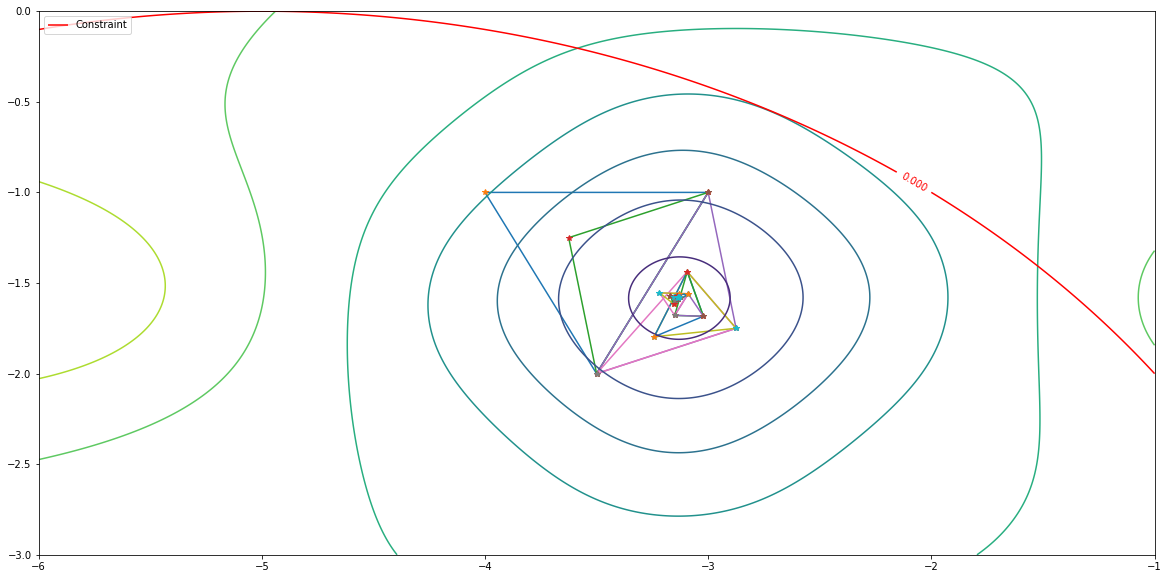

In [315]:
X_0 = [(-3,-1),(-4,-1),(-3.5,-2)]
optimal0,n_iter0 = Nelder_Mead_opt(f,f_const,X_0,n=3,eps=eps,alpha=1,beta=0.5,gamma=2,delta=0.5,print_flag=True,plot_flag=True)

# Initial guess that partially satisfy the constraint

Progress (%) and n_iteration are:  (0.0013527656377494456, 1)
Progress (%) and n_iteration are:  (0.0014826404724454759, 2)
Progress (%) and n_iteration are:  (0.001493197998370865, 3)
Progress (%) and n_iteration are:  (0.0015729627423758457, 4)
Progress (%) and n_iteration are:  (0.002399965287985965, 5)
Progress (%) and n_iteration are:  (0.005095685492810653, 6)
Progress (%) and n_iteration are:  (0.005554767482498569, 7)
Progress (%) and n_iteration are:  (0.014195649020567119, 8)
Progress (%) and n_iteration are:  (0.03912101683241755, 9)
Progress (%) and n_iteration are:  (0.016586707472876352, 10)
Progress (%) and n_iteration are:  (0.046565298213227885, 11)
Progress (%) and n_iteration are:  (0.08747044488170581, 12)
Progress (%) and n_iteration are:  (7.440260926480138, 13)
Progress (%) and n_iteration are:  (0.2548294574460775, 14)
Progress (%) and n_iteration are:  (0.3160638167585978, 15)
Progress (%) and n_iteration are:  (0.8768152620217665, 16)
Progress (%) and n_iterat

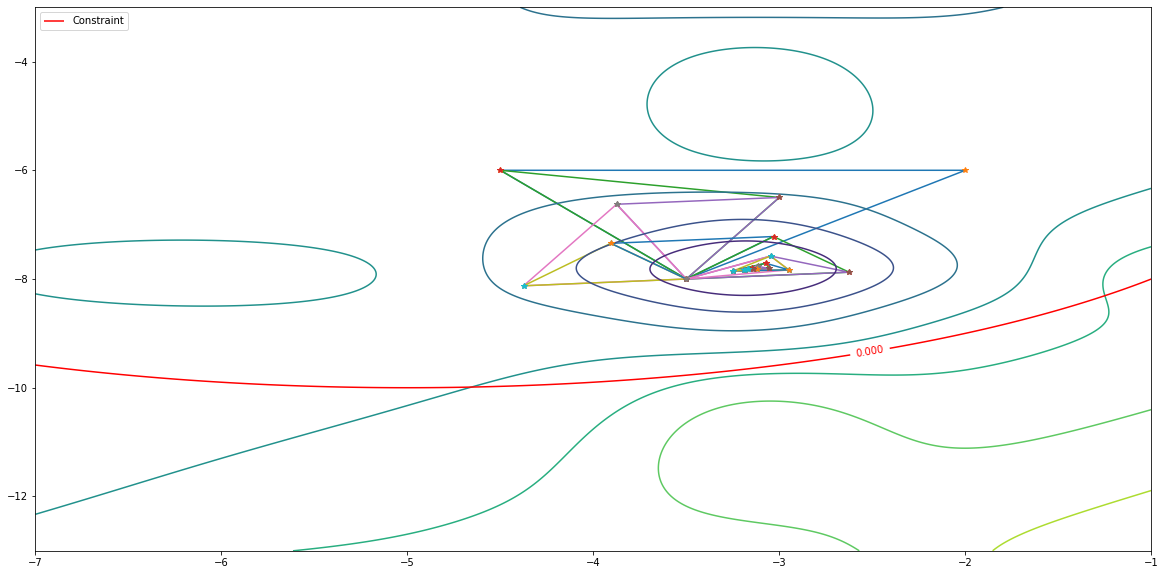

In [333]:
X_1 = [(-4.5,-6),(-2,-6),(-3.5,-8)]
optimal1,n_iter1 = Nelder_Mead_opt(f,f_const,X_1,n=3,eps=eps,alpha=alpha,beta=beta,
                                   gamma=gamma,delta=delta,print_flag=True,plot_flag=True)

In [334]:
#Different values for objective functions
optimal0[2],optimal1[2],optimal0[2]-optimal1[2]

(-106.76339053661114, -87.29809248856927, -19.465298048041873)

In [345]:
#Different Solutions due to different initial conditions
print("x = ",optimal0[0]," y = ",optimal0[1]," f(x,y) = ",optimal0[2])
print("x = ",optimal1[0]," y = ",optimal1[1]," f(x,y) = ",optimal1[2])

x =  -3.1298515303060412  y =  -1.5792781990021467  f(x,y) =  -106.76339053661114
x =  -3.170575872063637  y =  -7.811617478728294  f(x,y) =  -87.29809248856927


# Effect of changing the method parameters

In [342]:
X_0 = [(-3,-1),(-4,-1),(-3.5,-2)]

alpha_1 = 1.2 #Reflection
beta_1 = 0.1 #Contraction
gamma_1 = 3 #Expansion
delta_1 = 0.25 #Shrink

alpha_2 = 0.8 #Reflection
beta_2 = 0.43 #Contraction
gamma_2 = 1 #Expansion
delta_2 = 0.3 #Shrink

Progress (%) and n_iteration are:  (0.03661862129844226, 1)
Progress (%) and n_iteration are:  (0.0036967355001522122, 2)
Progress (%) and n_iteration are:  (0.12596696404322635, 3)
Progress (%) and n_iteration are:  (0.3779912398391804, 4)
Progress (%) and n_iteration are:  (0.15481909138823421, 5)
Progress (%) and n_iteration are:  (1.0002047596886328, 6)
Progress (%) and n_iteration are:  (1.5110001489310017, 7)
Progress (%) and n_iteration are:  (6.436920729672618, 8)
Progress (%) and n_iteration are:  (10.025060696930277, 9)
Progress (%) and n_iteration are:  (26.132048073307867, 10)
Progress (%) and n_iteration are:  (100, 11)


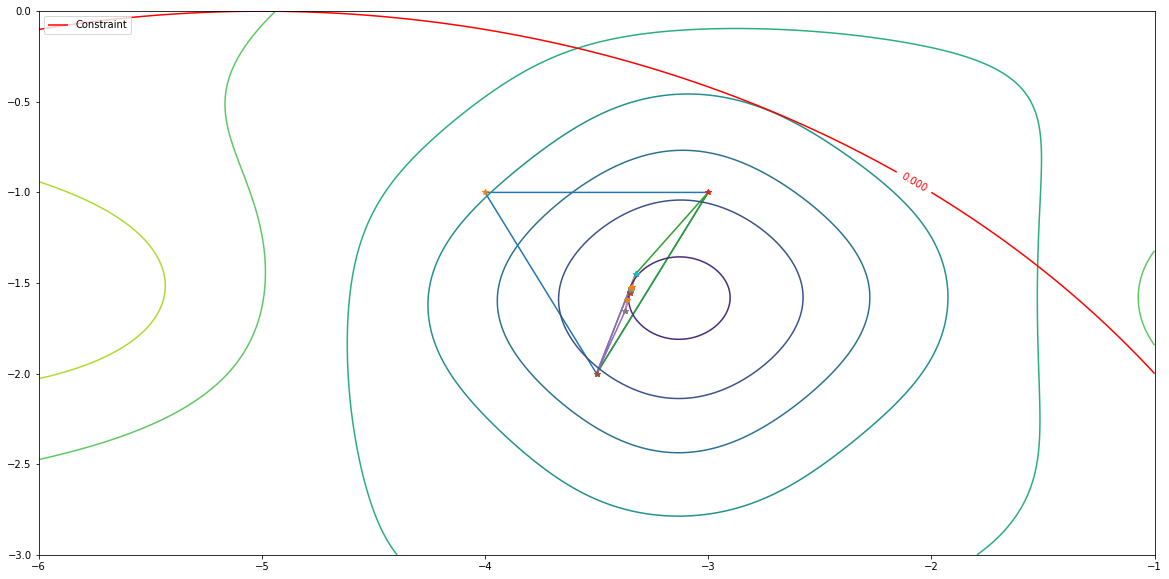

In [343]:
optimal_1,n_iter_1 = Nelder_Mead_opt(f,f_const,X_0,n=3,eps=eps,alpha=alpha_1,beta=beta_1,
                                   gamma=gamma_1,delta=delta_1,print_flag=True,plot_flag=True)

Progress (%) and n_iteration are:  (0.03661862129844226, 1)
Progress (%) and n_iteration are:  (0.07885312266164535, 2)
Progress (%) and n_iteration are:  (0.0030092028269203402, 3)
Progress (%) and n_iteration are:  (0.011804225384151061, 4)
Progress (%) and n_iteration are:  (0.01380953739016395, 5)
Progress (%) and n_iteration are:  (0.22075230508686733, 6)
Progress (%) and n_iteration are:  (1.9702310780778216, 7)
Progress (%) and n_iteration are:  (0.09315612414309146, 8)
Progress (%) and n_iteration are:  (1.2036891590377596, 9)
Progress (%) and n_iteration are:  (22.586589905254392, 10)
Progress (%) and n_iteration are:  (1.3102883335392157, 11)
Progress (%) and n_iteration are:  (23.198750684690953, 12)
Progress (%) and n_iteration are:  (13.967207426358193, 13)
Progress (%) and n_iteration are:  (28.033743024346748, 14)
Progress (%) and n_iteration are:  (32.93438979344106, 15)
Progress (%) and n_iteration are:  (100, 16)


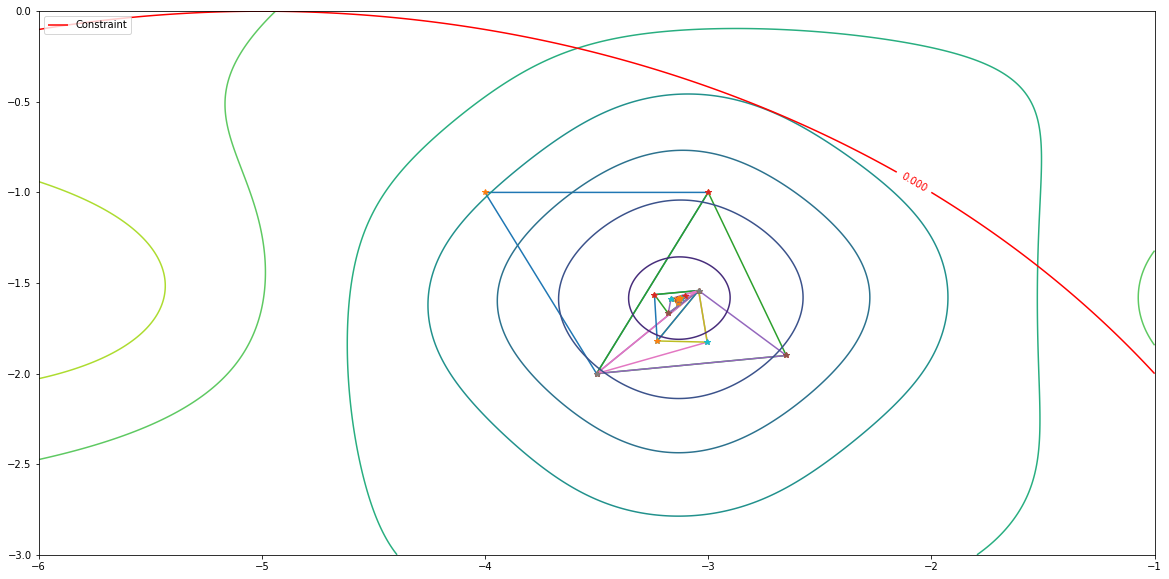

In [339]:
optimal_2,n_iter_2 = Nelder_Mead_opt(f,f_const,X_0,n=3,eps=eps,alpha=alpha_2,beta=beta_2,
                                   gamma=gamma_2,delta=delta_2,print_flag=True,plot_flag=True)

In [346]:
optimal_1[2],optimal_2[2],optimal_1[2]-optimal_2[2]

(-100.25489870913123, -106.76092832061104, 6.506029611479818)

In [347]:
print("x = ",optimal_1[0]," y = ",optimal_1[1]," f = ",optimal_1[2])
print("x = ",optimal_2[0]," y = ",optimal_2[1]," f = ",optimal_2[2])

x =  -3.3443266541132806  y =  -1.5273790788203123  f =  -100.25489870913123
x =  -3.125285520292717  y =  -1.5808190986723252  f =  -106.76092832061104


# Conclusion
A local minimum could be achieved but due to non-convexity of the problem and the usage of Nelder-Mead method (heuristic method) a global minimum is hard to be achieved. Changing initial conditions or method parameters can lead to different solutions.

# Implementation of Coordinate descent method

In [381]:
def coord_descent_opt(obj_fun,X_0,eps,alpha,print_flag=True,plot_flag=True):
    
    x = Symbol('x')
    y = Symbol('y')
    f = lambdify([x,y], obj_fun, 'numpy')
    f_x = lambdify([x,y], obj_fun.diff(x), 'numpy')
    f_y = lambdify([x,y], obj_fun.diff(y), 'numpy')
    
    coords = []
    n_iter = 0
    flag = True
    coords.append(X_0)
    f_opt = np.NaN
    while flag:
        
        n_iter = n_iter +1
        xi = coords[len(coords)-1][0]
        yi = coords[len(coords)-1][1]
        
        f_eval_0 = f(xi,yi)
        f_x_eval = f_x(xi,yi)
        f_y_eval = f_y(xi,yi)
        
        xi = xi - alpha*f_x_eval
        yi = yi - alpha*f_y_eval
        f_eval_1 = f(xi,yi)
        
        coords.extend([(xi,yi)])
        if print_flag:
            print("Function value = ",f_eval_1," Iteration : ",n_iter)
            
        if abs(f_eval_1-f_eval_0) <= eps:
            f_opt = f_eval_1
            flag = False
            break
            
            
    if plot_flag:
        xx = [x[0] for x in coords]
        yy = [x[1] for x in coords]
        
        x, y = np.meshgrid(np.linspace(min(xx)-0.5*abs(min(xx)),max(xx)+0.5*abs(max(xx)) , 1000),
                   np.linspace(min(yy)-0.5*abs(min(yy)),max(yy)+0.5*abs(max(yy)), 1000))

        fig, ax = plt.subplots(1,figsize=(20, 10))
        C1 = ax.contour(x, y, f(x, y))
        
        
        plt.plot(xx,yy)
                           
    
    return  coords[len(coords)-1],f_opt,n_iter  
    

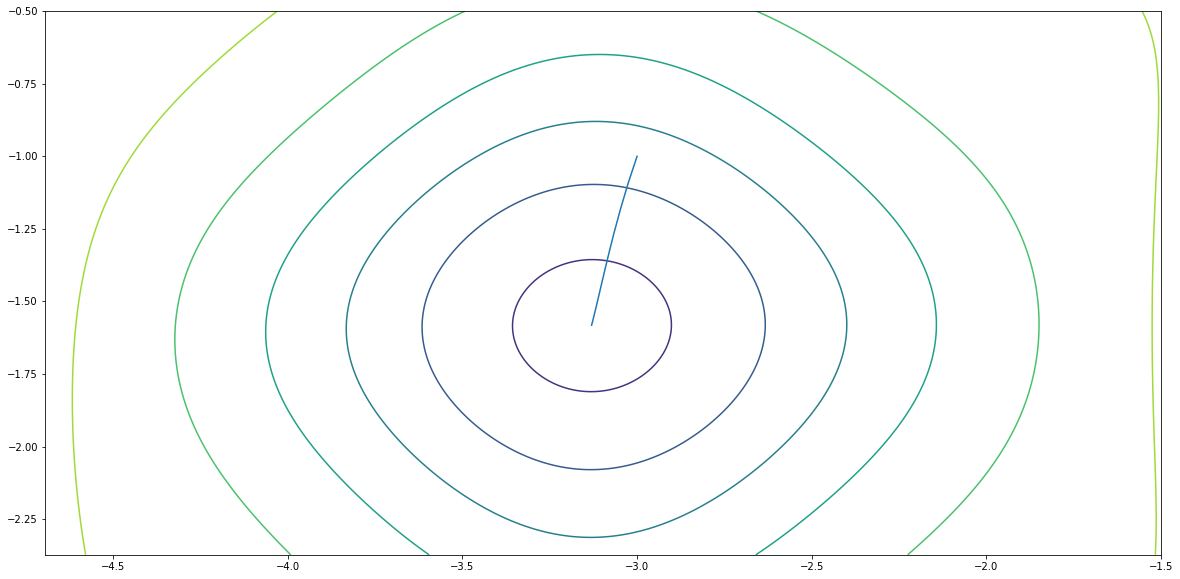

In [387]:
X_0 = (-3,-1)
X_cd,f_opt_cd,n_iter_cd = coord_descent_opt(obj_fun,X_0,1e-5,0.001,print_flag=False,plot_flag=True)



In [390]:
print("Coordinate descent method: ")
print("x = ",X_cd[0]," y = ",X_cd[1]," f(x,y) = ",f_opt_cd," Iterations : ",n_iter_cd)
print()
print("Nelder-Mead method: ")
print("x = ",optimal0[0]," y = ",optimal0[1]," f(x,y) = ",optimal0[2], " Iterations : ",n_iter0)

Coordinate descent method: 
x =  -3.1301892557532263  y =  -1.5819142195818445  f(x,y) =  -106.7645291809701  Iterations :  26

Nelder-Mead method: 
x =  -3.1298515303060412  y =  -1.5792781990021467  f(x,y) =  -106.76339053661114  Iterations :  20


# Conclusion
Nelder-Mead method and coordinate descent method performances are very similar
- Number of oracle calls/iteration for Nelder-Mead is `4`, taking into consideration that it is a Zero-order
- Number of oracle calls/iteration for Coordinate descent method is `4` , taking into consideration that it is a First-order

## Hence, one could assume that for the performed experiment conditions, Nelder-Mead method prevails over coordinate descent method